# Klasyfikacja tweetów Elona Muska

### Projekt realizuje grupa:

*  Wiktor Bajor **249459**
*  Adam Kubiak **249480**


### Opis wykonywanego zadania: 

&nbsp; W ramach projektu grupa będzie realizować zadanie klasyfikacji binarnej tweetów Elona Muska. Wykonywane zadanie będzie opierać się o zebranie tweetów sławnych ludzi, takich jak politycy, przedsiębiorcy, sportowcy, celebryci, influencerzy oraz Elon Musk. Pozyskiwanie danych będzie realizowana poprzez publiczny interfejs programowania aplikacji (API), udostępniony przez Twitter. Przy czym możliwa ilość tweetów do pobrania to pięćset tysięcy, co powinno być wystarczającą ilością danych. Dzięki udostępnionemu API można uzyskać dostęp do takich danych jak, treść publikacji, godzina publikacji, ilość polubień czy ilość retweetów. Po ukończeniu etapu pozyskiwania danych kolejnym zadaniem, będzie przeanalizowanie tweetów, mając na uwadze takie elementy jak ilość retweetów, ilość polubień, występowanie pewnych elementów taki jak linki, oznaczenia czy też sentyment oraz suiektywność umieszczonego wpisu. Dodatkowo w ramach analizy zaostaną wykorzystowe anlizy języka naturalnego udostępnione przez Twitter. Na podstawie dokonanej analizy zostaną wybrane najbardziej charakterystyczne cechy tweetów Elona Muska. Ostatnim elementem projektu będzie utworzenie i wytrenowanie (na bazie wcześniej wybranych cech) klasyfikatora, który będzie oceniał czy dany tweet był napisany przez Elona Muska czy też nie. Wykonana analiza oraz klasyfikator mogłyby zostać wykorzystane do stworzenia cyfrowego sobowtóra Elona Muska.

### Eksploracyjna analiza danych

#### Pochodzenie danych

Dane pobierane są bezpośrednio z Twittera. Do pozyskiwania wykorzystane zostało API V2, udostępnione bezpośrednio przez Twitter oraz dedykowana biblioteka Tweepy, która umożliwiła wygodne pobieranie danych z wykorzystaniem języka Python3. 


Zdecydowano się na poddanie analizie kilka publicznych osób o zbliżonej ilości obserwatorów. Do wybrania odpowiednich kont wykorzystano stronę https://www.socialtracker.io/toplists/top-50-twitter-users-by-followers/, na której została zebrana lista 50 najbardziej popularnych kont. W trakcie wyboru kont starano się aby wybrane konta reprezentowały różne części społeczeństwa(politycy, celebryci, przedsiębiorcy, artyści oraz platformy medialne).

Finalnie wybrano:

* Elon Musk $-$ ~`115` mln obserwujących
* Barack Obama $-$ ~`133` mln obserwujących
* Justin Bieber $-$ ~`113` mln obserwujących
* Cristiano Ronaldo $-$ ~`104` mln obserwujących
* YouTube $-$ ~`77` mln obserwujących
* KimKardashian ~`74` mln obserwujących
* Ellen DeGeneres $-$ ~`77` mln obserwujących
* Twitter $-$ ~`64` mln obserwujących
* CNN $-$ ~`64` mln obserwujących
* Bill Gates $-$ ~`61` mln obserwujących
* Joe Biden $-$ ~`36` mln obserwujących


Skrypty realizujące pobieranie oraz zapisywanie tweetów w formacie, zawarte są w plikach `tweet_getter.ipynb` oraz `tweets_pd_frames.ipynb`.
Funkcje pomocnicze umieszczone są w `helper_functions.py`. 

### Opis zmiennych

Api Twittera umożliwia pobranie wielu danych. W ramach projektu zdecydowano się na pobranie danych oraz wydobyciu z nich następujących informacji:

* `created_at`(data, string) - jest to data zamieszczenia wpisu z dokładnością co do sekundy, tą informacje można wykorzystać do sprawdzenia aktywności użytkownika w trakcie doby.
* `source`(string) - źródło publikacji wiadomości, na przykład czy wpis był wykonany z aplikacji z iPhone czy ze strony internetowej.
* `possibly sensitive`(bool) - zawiera informacje czy dany wpis zawiera treści wrażliwe.
* `lang`(string) - język wpisu.
* `has_text`(binary integer value[0,1]) - informacja, czy wpis zawierał "czysty tekst"(bez emoji, linków, oznaczeń czy hashtagów).
* `has_link`(binary integer value[0,1]) - informacja, czy wpis zawierał link.
* `has_hashtag`(binary integer value[0,1]) - informacja, czy wpis zawierał hashtag.
* `has_emoji`(binary integer value[0,1]) - informacja, czy wpis zawierał emoji.
* `sentiment`(float) - sentyment wpisu w skali od -1 do 1 wyliczony z treści wpisu z wykorzystaniem biblioteki `TextBlob`(zastosowany tylko do anglojęzycznych wpisów).
* `subjectivity`(float) - subiektywność wpisu w skali od 0 do 1 wyliczony z treści wpisu z wykorzystaniem biblioteki `TextBlob`(zastosowany tylko do anglojęzycznych wpisów).
* `retweet count`(int) - liczba 'podania dalej wpisu'.
* `reply count`(int) - liczba odpowiedzi.
* `like count`(int) - liczba polubień wpisu.
* `quote count`(int) - liczba cytowań wpisu.
* `is Elon Musk`(binary integer value[0,1]) - identyfikuje czy dany jest wpis jest utworzony przez Elona Muska.
* `context annotations domain`(string) - domena wypowiedzi, np. marka, osoba. Twitter dostarcza do sześciu takich analiz.
* `context annotations entity`(string) - podmiot wypowiedzi, jeżeli wpis był odnośnie marki, w tym polu będzie nazwa marki np. Coca-Cola. Twitter dostarcza do sześciu takich analiz.
* `annotations`(tuple(float, string,string)) - połączenie dwóch powyższych razem z prawdopodobieństwem poprawności analizy.


#### Wczytanie danych

Pobrane dane zostały zapisane w czterech plikach typu `*.csv` w folderze `user_data`. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from helper_functions import *

data_folder = 'user_data'

data_frame = pd.read_csv(f'{data_folder}/main_df.csv')
data_annotations_frame = pd.read_csv(f'{data_folder}/annotation_df.csv')
old_elon_basic = pd.read_csv(f'{data_folder}/old_elon_basic.csv')
old_elon_annotations = pd.read_csv(f'{data_folder}/old_elon_annotations.csv')


data_frame["created at"] = pd.to_datetime(data_frame["created at"])
old_elon_basic["created at"] = pd.to_datetime(old_elon_basic["created at"])

#### Podstawowa ramka danych

Poniżej została przedstawiona podstawowa ramka danych, nieuwzględniająca kolumn `context annotations domain`, `context annotations entity` oraz
`annotations`.

In [2]:
data_frame.head()

,is Elon Musk,created at,source,possibly sensitive,lang,has_text,has_link,has_hashtag,has_at,has_emoji,sentiment,subjectivity,retweet count,reply count,like count,quote count
0,1,2022-12-12 19:46:04+00:00,Twitter for iPhone,0,und,0,1,0,0,1,0.0,0.0,20135,14379,238424,3363
1,1,2022-12-12 19:36:52+00:00,Twitter for iPhone,0,en,1,1,0,0,0,0.0,0.0,27679,9635,118548,1714
2,1,2022-12-12 14:21:31+00:00,Twitter for iPhone,0,en,1,0,0,0,0,0.8,0.7,37603,27237,337208,4261
3,1,2022-12-12 12:25:32+00:00,Twitter for iPhone,0,en,1,0,0,0,0,0.0,0.0,66507,42222,470431,10681
4,1,2022-12-12 11:24:29+00:00,Twitter for iPhone,0,en,1,0,0,0,0,0.0,0.0,10073,6045,138343,522


### Opis zmiennych 

Poza podstawowymi informacjami Twitter umożliwia pobranie gotowych analiz tekstu. Utworzone analizy zawierają, do siedmiu różnych analiz. Pięć pierwszych analiz zawiera informacje o dziedzinie wpisu oraz o podmiocie wpisu. Ostatnia, szósta analiza zawiera prawdopodobieństw trafności analizy, dziedzinę oraz istotę wpisu. Ostatnia analiza nie jest dostępna dla każdego wpisu.     

In [3]:
data_annotations_frame.head()

,is Elon Musk,context annotations domain 0,context annotations entity 0,context annotations domain 1,context annotations entity 1,context annotations domain 2,context annotations entity 2,context annotations domain 3,context annotations entity 3,context annotations domain 4,context annotations entity 4,context annotations domain 5,context annotations entity 5,annotations
0,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN
1,True,Person,Donald Trump,Politician,Donald Trump,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,News Vertical,News,News Vertical,Business & finance news,"[0.9636, 'Twitter', 'Other']"
2,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,"[0.9003, 'Covidians', 'Other']"
3,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN
4,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN


#### Poniżej wykonano połączenie wcześniej przedstawionych ramek.    

In [4]:
old_elon_data = pd.concat([old_elon_basic, old_elon_annotations], axis=1)
old_elon_data = old_elon_data.loc[:,~old_elon_data.columns.duplicated()].copy()

data_frame = pd.concat([data_frame, data_annotations_frame], axis=1)
data_frame = data_frame.loc[:,~data_frame.columns.duplicated()].copy()
data_frame = pd.concat([data_frame, old_elon_data], axis=0)

In [5]:
data_frame.head()

,is Elon Musk,created at,source,possibly sensitive,lang,has_text,has_link,has_hashtag,has_at,has_emoji,...,context annotations entity 1,context annotations domain 2,context annotations entity 2,context annotations domain 3,context annotations entity 3,context annotations domain 4,context annotations entity 4,context annotations domain 5,context annotations entity 5,annotations
0,1,2022-12-12 19:46:04+00:00,Twitter for iPhone,0,und,0,1,0,0,1,...,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN
1,1,2022-12-12 19:36:52+00:00,Twitter for iPhone,0,en,1,1,0,0,0,...,Donald Trump,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,News Vertical,News,News Vertical,Business & finance news,"[0.9636, 'Twitter', 'Other']"
2,1,2022-12-12 14:21:31+00:00,Twitter for iPhone,0,en,1,0,0,0,0,...,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,"[0.9003, 'Covidians', 'Other']"
3,1,2022-12-12 12:25:32+00:00,Twitter for iPhone,0,en,1,0,0,0,0,...,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN
4,1,2022-12-12 11:24:29+00:00,Twitter for iPhone,0,en,1,0,0,0,0,...,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN


### Badanie brakujących zmiennych 

Twitter udostępnia dane, które są kompletne, ciężko znaleźć jakieś braki. 
W niektórych przypadkach brakuje analizy kontekstu wypowiedzi.
Brak ten nie jest istotny z punkt widzenia całego zbiory, ponieważ całkowity brak analizy tekstu występuje tylko dla kilku próbek.
Próbki obarczone tym problemem mogą zostać wykluczone.
Kolejnym elementem, który bywa wybrakowany jest treść wpisu(szczególnie w przypadku Elona Muska). Mimo braku treści wpisu, nadal informacje dostępne są dane o ilości odpowiedzi czy polubień, więc takie dane mogą zostać wykorzystane.

### Czyszczenie danych

W ramach czyszczenia danych zostają usunięte wszystkie wpisy w innych językach niż:

* `en` - angielski
* `art`- język sztuczny(artificial language)
* `zxx` - wpisy bez kontekstu lingwistycznego.

Usunięto także wszystkie wpisy, ze źródeł, których liczba nie przekraczała dwunastu.   

In [93]:
values = ['en','art','zxx']
data_frame = data_frame.groupby('source').filter(lambda x : len(x) > 12)
data_frame = data_frame[data_frame.lang.isin(values) == True]

### Analiza danych numerycznych 

W przypadku dostępnych danym, kilka zmiennych to dane numeryczne:

* `like count`
* `retweet count`
* `quote count`
* `reply count`
* `sentiment`
* `subjectivity`

Żeby lepiej przyjrzeć się danym numerycznym, wykorzystano podstawowe własności.

#### Średnia

Analizując wartości średnie liczby polubień, odpowiedzi, cytowań czy podawania dalej można zauważyć, że 
każda wartości poza średnim sentymentem jest kilkukrotnie wyższa. Można zauważyć iż największa różnica bo
aż dziesięciokrotna jest w średniej liczbie odpowiedzi na wpis. Co może świadczyć o tym iż wpisy Elona Muska bardziej 
angażują społeczność.

In [7]:
numeric_columns = ["like count","retweet count", 'quote count', 'reply count']
data_frame.groupby(by='is Elon Musk')[numeric_columns].mean()

,like count,retweet count,quote count,reply count,sentiment,subjectivity
is Elon Musk,,,,,,
0,38562.730977,4407.751990,838.538204,1751.290672,0.174181,0.353437
1,280428.536667,24795.154444,4615.570000,19566.775556,0.115061,0.283255


#### Mediana

Porównując mediane wpisów Elona Muska do pozostałych użytkowników, można zauważyć iż w przypadku wpisów
Elona Muska mediany są bardziej zbliżone do średnich niż w przypadku pozostałych użytkowników. 
Szczególnie widać to przy ilości cytowań. Takie zachowanie może wynikać z faktu, że Elon ma bardziej stałą grupę
odbiorców, natomiast w przypadku innych reakcje mogą bardziej wynikać ze szczególnych zdarzeń.   


In [8]:
data_frame.groupby(by='is Elon Musk')[numeric_columns].median()

,like count,retweet count,quote count,reply count,sentiment,subjectivity
is Elon Musk,,,,,,
0,4126.5,443.5,81.0,280.0,0.078977,0.360417
1,165382.0,12078.0,1462.5,10381.5,0.000000,0.162500


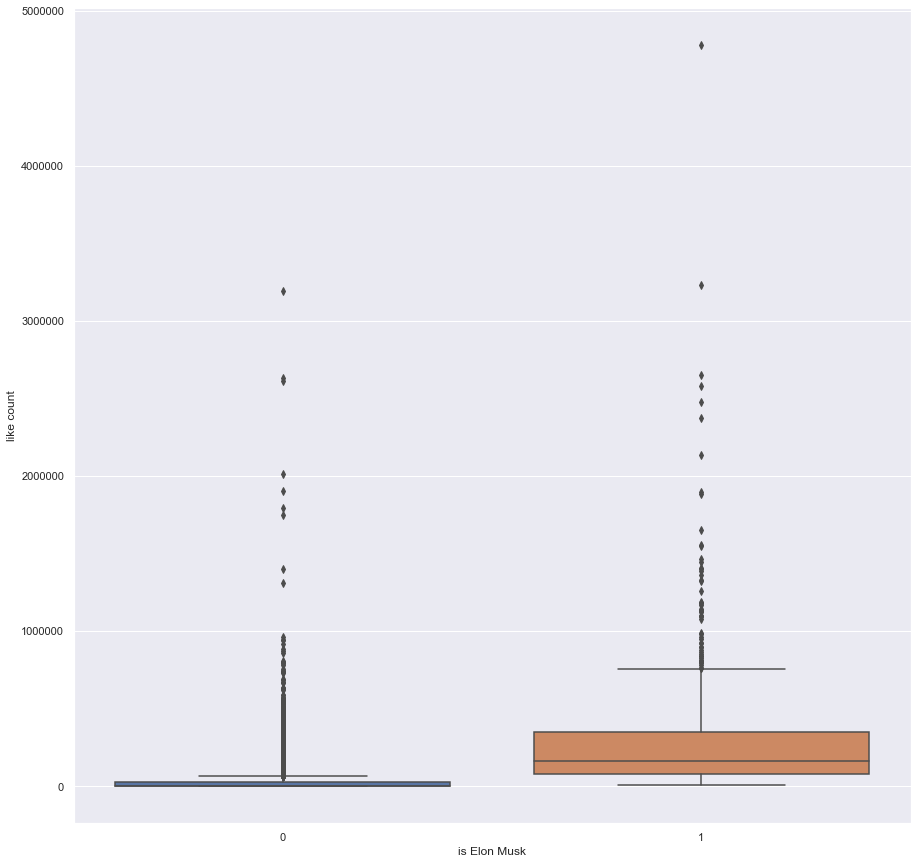

In [94]:
import seaborn as sb
sb.set(rc={"figure.figsize":(15, 15)})
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['like count']);

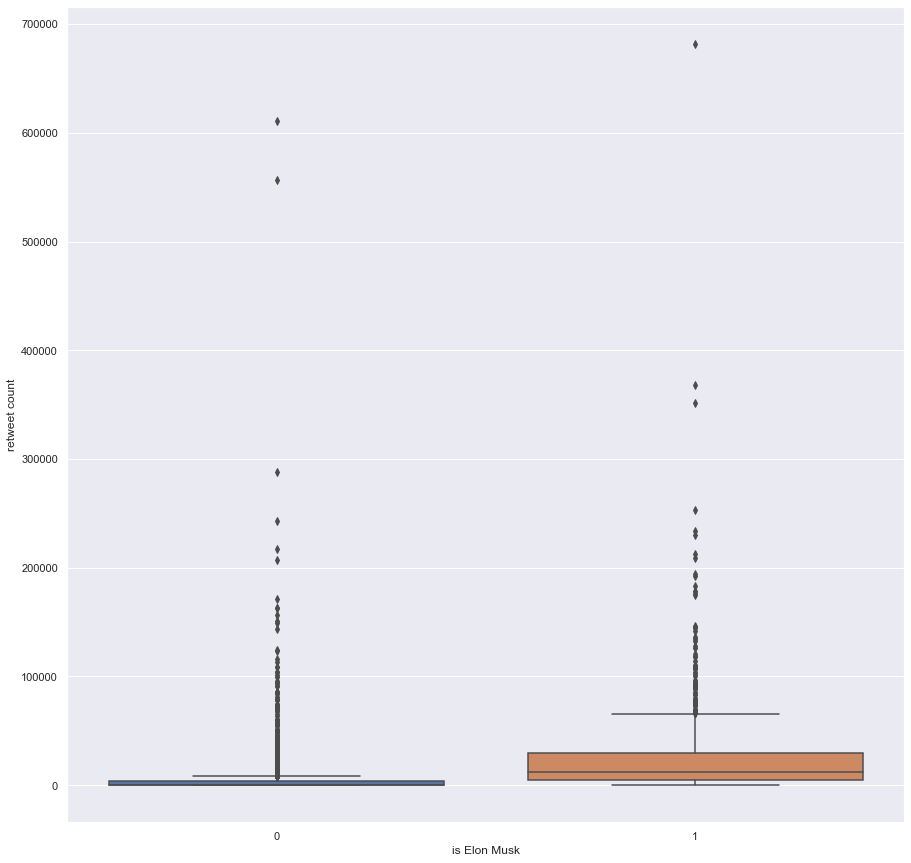

In [95]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['retweet count']);

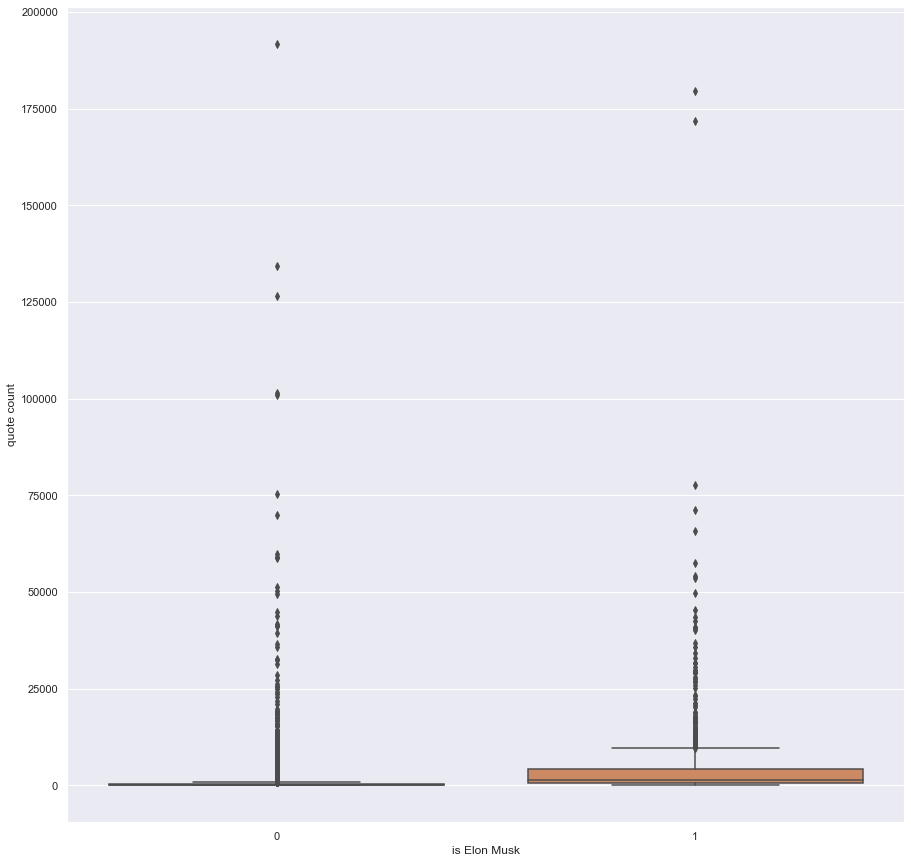

In [96]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['quote count']);

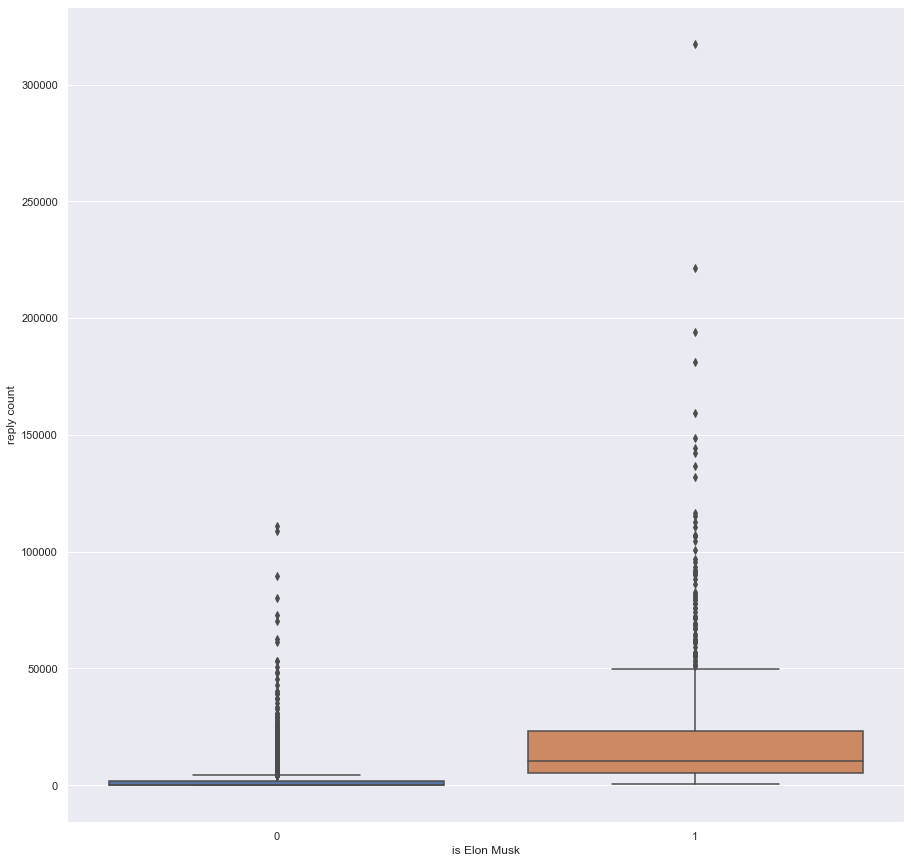

In [97]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['reply count']);

#### Sentyment oraz subiektywność

W obu przypadkach zarówno średniej jak i medianie wartości sentymentu wpisu są podobne.
W przypadku subiektywności średnie wartości są zbliżone natomiast mediany różnią się znacząco. 

In [78]:
numeric_columns = ['sentiment', 'subjectivity']
data_frame.groupby(by='is Elon Musk')[numeric_columns].mean()

,sentiment,subjectivity
is Elon Musk,,
0,0.174181,0.353437
1,0.115061,0.283255


In [98]:
data_frame.groupby(by='is Elon Musk')[numeric_columns].median()

,sentiment,subjectivity
is Elon Musk,,
0,0.078977,0.360417
1,0.000000,0.162500


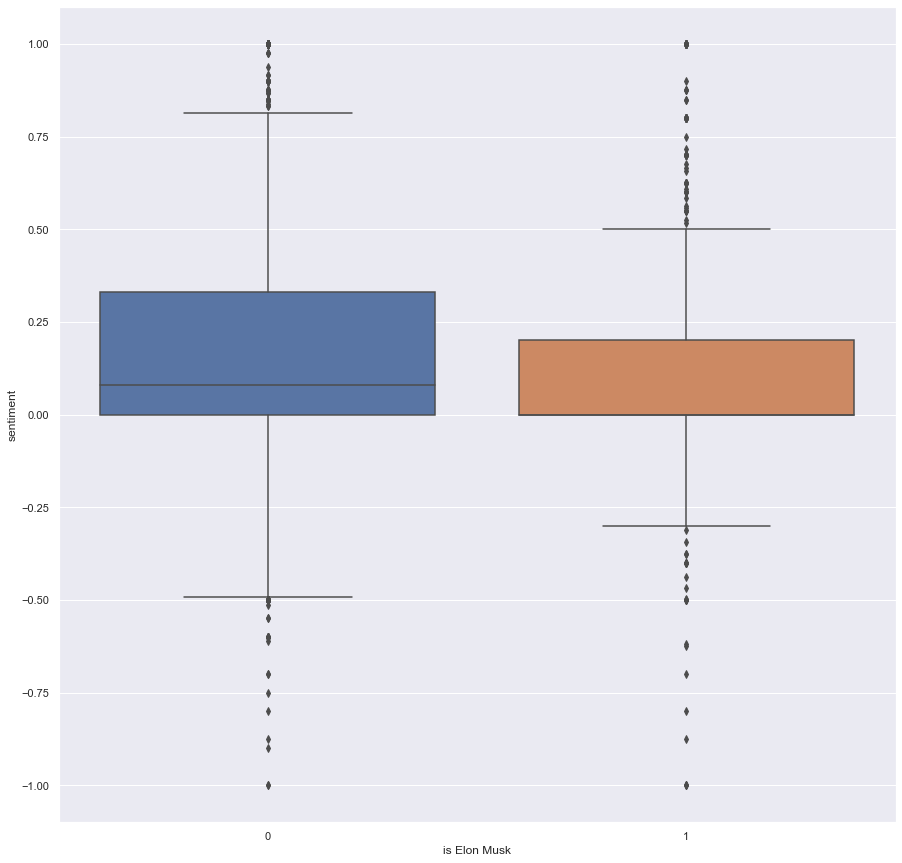

In [13]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['sentiment'])

#### Subiektywność  

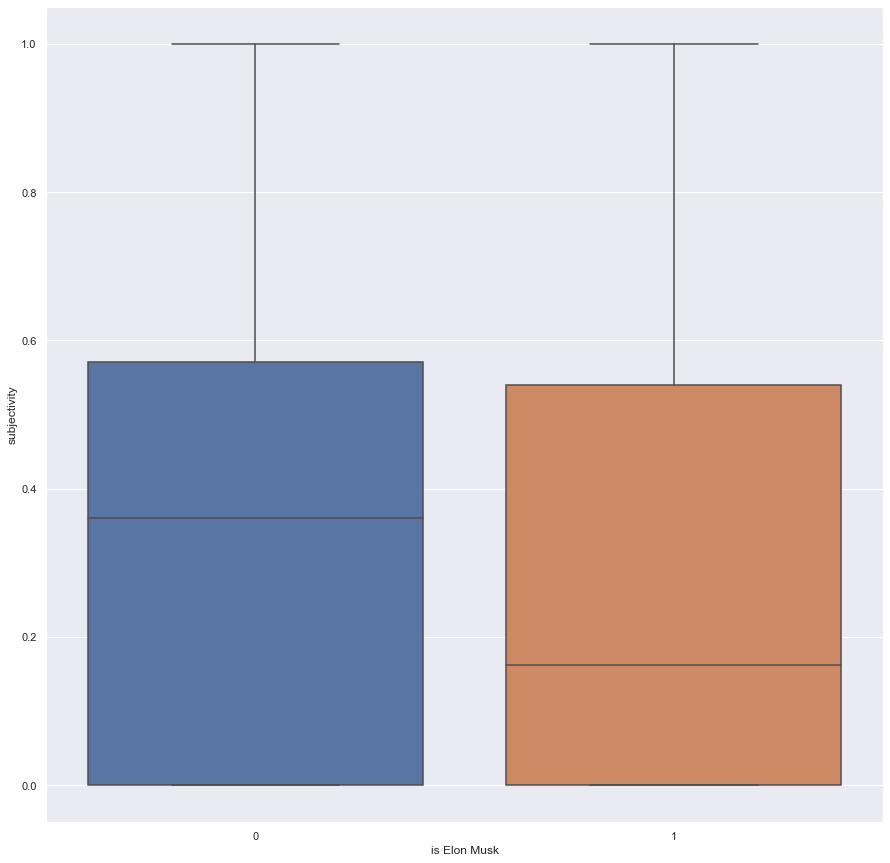

In [14]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['subjectivity'])

In [47]:
x = ['has_text', 'has_link', 'has_hashtag', 'has_at', 'has_emoji']
data_frame.groupby(by='is Elon Musk')[x].mean()

,has_text,has_link,has_hashtag,has_at,has_emoji
is Elon Musk,,,,,
0,0.969755,0.753582,0.235753,0.145654,0.178765
1,0.885556,0.332222,0.024444,0.003333,0.050000


### Mapa cieplna

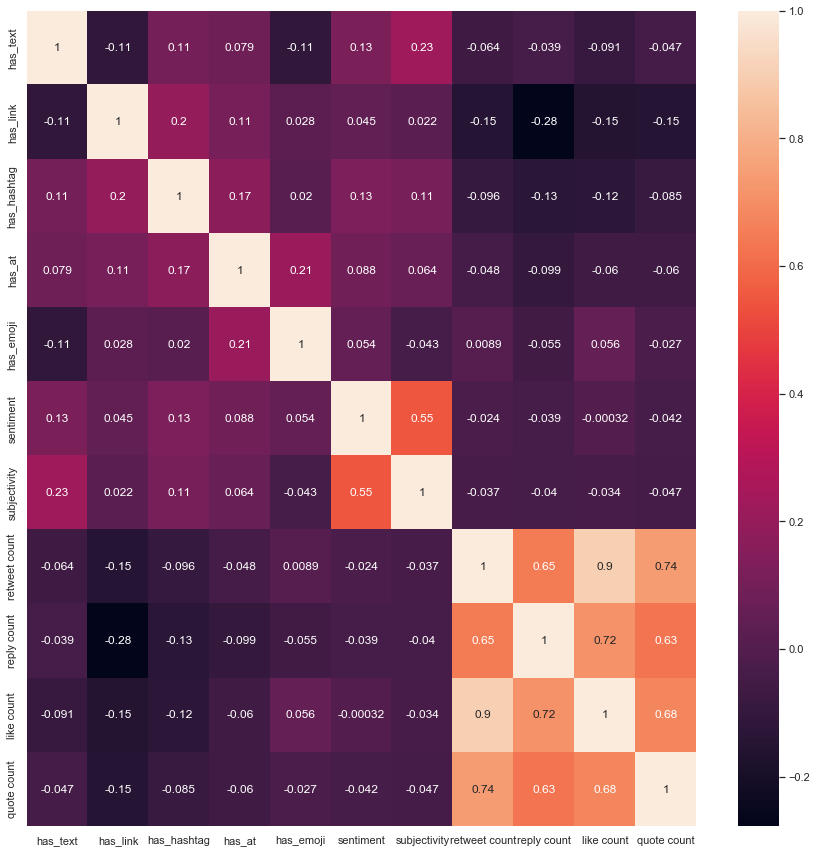

In [17]:
columns = ['has_text', 'has_link', 'has_hashtag', 'has_at',	'has_emoji', 'sentiment', 'subjectivity', 'retweet count', 'reply count', 'like count',	'quote count']
corr_matrix=data_frame[columns].corr()
sb.heatmap(corr_matrix, annot=True);

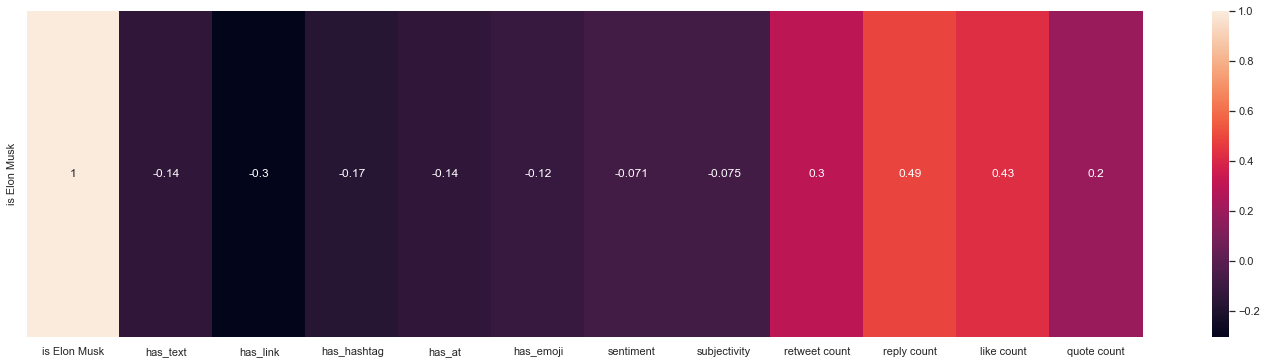

In [18]:
columns = ['is Elon Musk', 'has_text', 'has_link', 'has_hashtag', 'has_at',	'has_emoji', 'sentiment', 'subjectivity', 'retweet count', 'reply count', 'like count',	'quote count']

plt.figure(figsize=(25, 6))
corr_matrix=data_frame[columns].corr()[:1]
sb.heatmap(corr_matrix, annot=True);

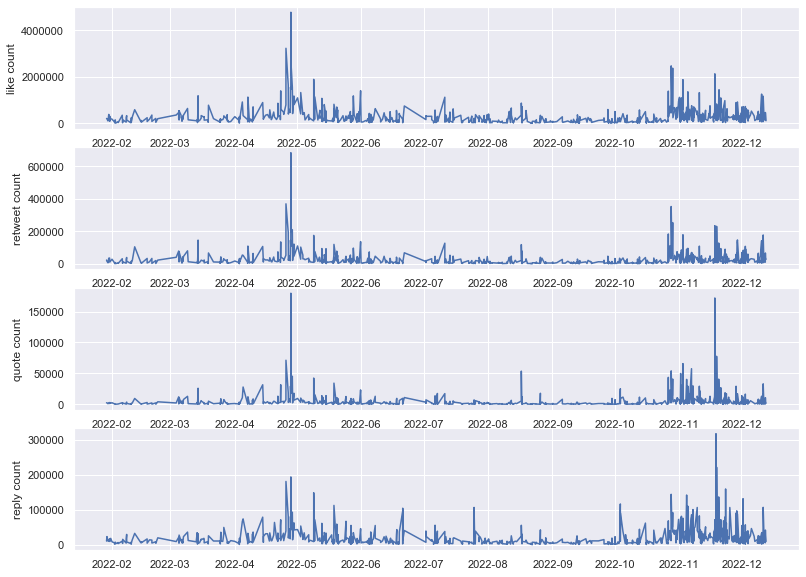

In [19]:
data_frame_elon = data_frame.loc[data_frame['is Elon Musk'] == 1] 
data_frame_not_elon = data_wframe.loc[data_frame['is Elon Musk'] == 0]
ylabels = ["like count","retweet count", 'quote count', 'reply count']
plot_time_line_charts(data_frame_elon, ylabels)

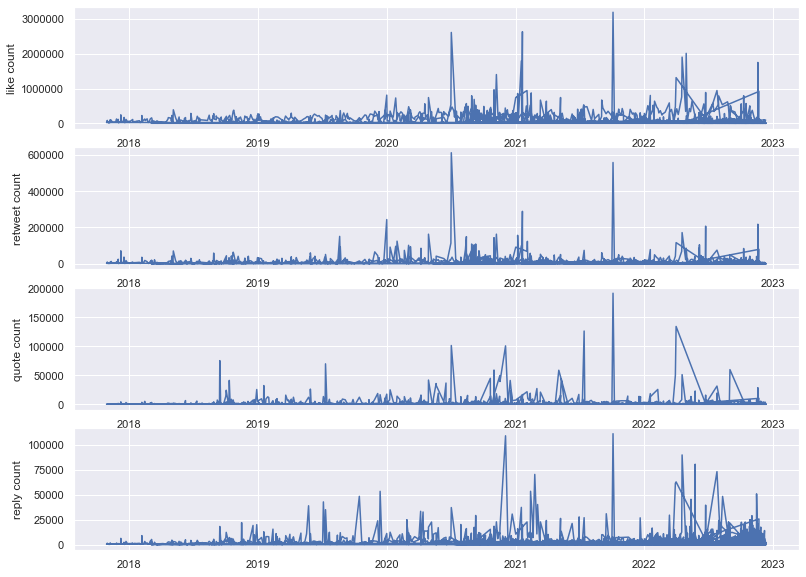

In [20]:
plot_time_line_charts(data_frame_not_elon, ylabels)

### Najbardziej popolrany wpis Elona Muska 


***Next I’m buying Coca-Cola to put the cocaine back in***

***the bird is freed***

#### Ilość wpisów w zależności od pory dnia


Sprawdzono ilość wpisów w zależności od godziny na przestrzeni doby.
W celu przeanalizowania tej zależności utworzono histogram wpisów w zależności od godziny.
Histogram został zamieszczony poniżej. Analizując histogram można zauważyć bardzo ciekawą zależność 
Elon Musk jest dużo bardziej aktywny od pozostałych użytkowników między 0 a 8. 
W pozostałych godzinach Elon jest mniej aktywny od pozostałych użytkowników.  


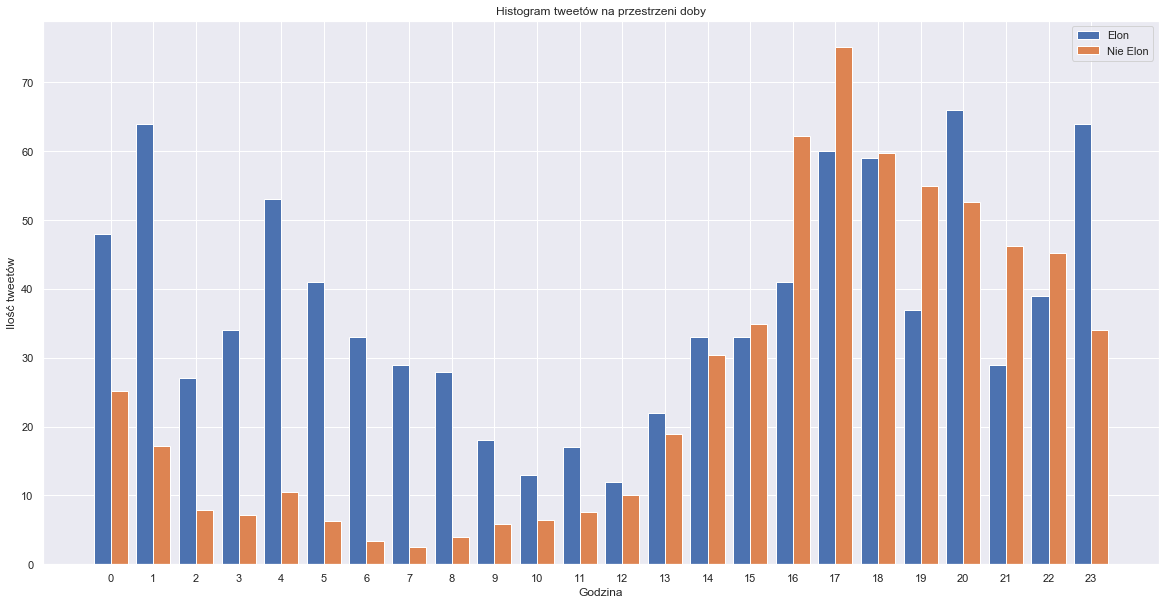

In [21]:

data_frame_not_elon_count_by_hour = data_frame_not_elon['created at'].groupby(data_frame_not_elon['created at'].dt.hour).count() / 10
elon_data_count_by_hour = data_frame_elon['created at'].groupby(data_frame_elon['created at'].dt.hour).count()


data_count_by_hour = fill_missing_hours_with_zero(data_frame_not_elon_count_by_hour.to_dict())
plot_histogram_of_tweet_during_time(elon_data_count_by_hour, data_count_by_hour, 'Ilość tweetów', 'Histogram tweetów na przestrzeni doby')

### Analiza sentymentu w ciągu dnia

Analizując sentyment wpisów na przestrzeni doby. Można zaobserwować iż wpisy Elona Muska były wyjątkowe pozytywne 
o godzinie 10 oraz 12. W tylko w tych godzinach sentyment wpisów Elona Muska znacząco przewyższa średni sentyment
pozostałych użytkowników.     

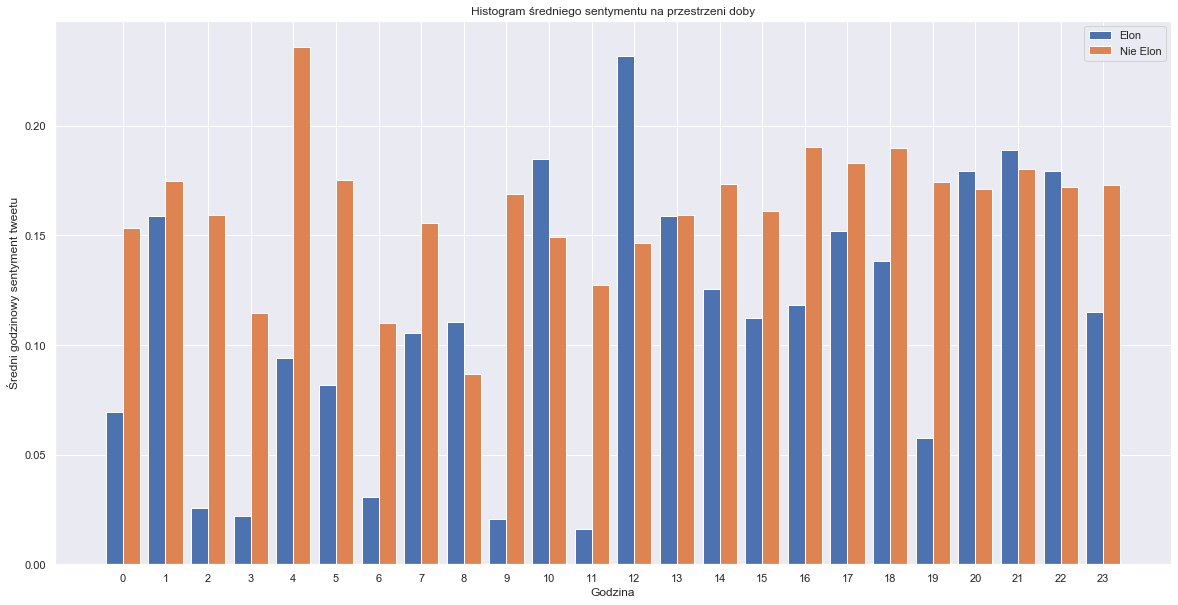

In [22]:
elon_sentiment = data_frame_elon.groupby(data_frame_elon['created at'].dt.hour).describe()['sentiment']['mean']
not_elon_sentiment = data_frame_not_elon.groupby(data_frame_not_elon['created at'].dt.hour).describe()['sentiment']['mean']

data_count_by_hour = fill_missing_hours_with_zero(not_elon_sentiment.to_dict())
plot_histogram_of_tweet_during_time(elon_sentiment, data_count_by_hour, 'Średni godzinowy sentyment tweetu', 'Histogram średniego sentymentu na przestrzeni doby')


### Analiza danych nienumerycznych

#### Źródło wpisu
Analizując zmienne nienumeryczne można zaobserwować ciekawe zależności. Rozważając źródło dodania wpisu można zauważyć, 
że Elon Musk zawsze dodaje wpisy z aplikacji mobilnej na IPhone. Pozostali użytkownicy dodawali wpisy z różnych źródeł.

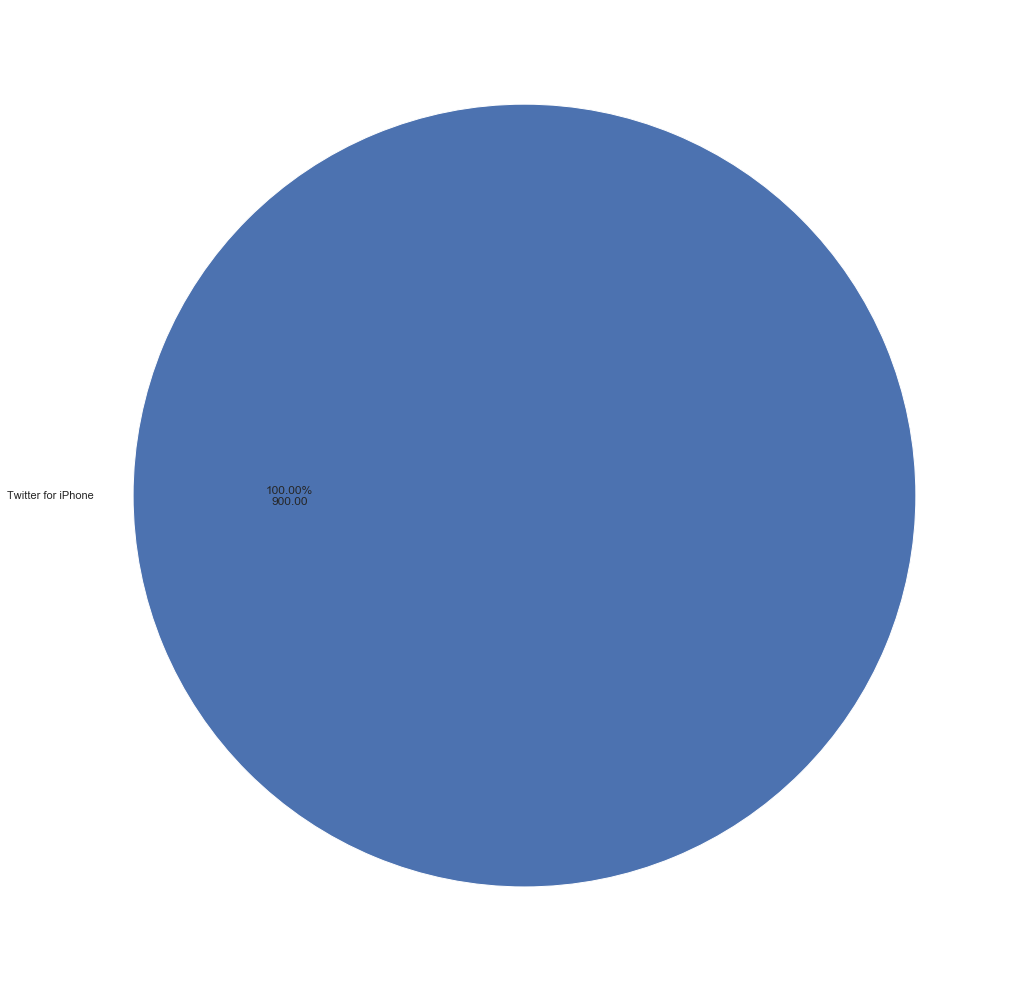

In [23]:
def fmt(x):
    return f'{x:.2f}%\n{total*x/100:.2f}'
plt.figure(figsize=(18,18))

total = data_frame_elon['source'].value_counts().values.sum()
plt.pie(data_frame_elon['source'].value_counts().values, labels=data_frame_elon['source'].value_counts().index, autopct=fmt);


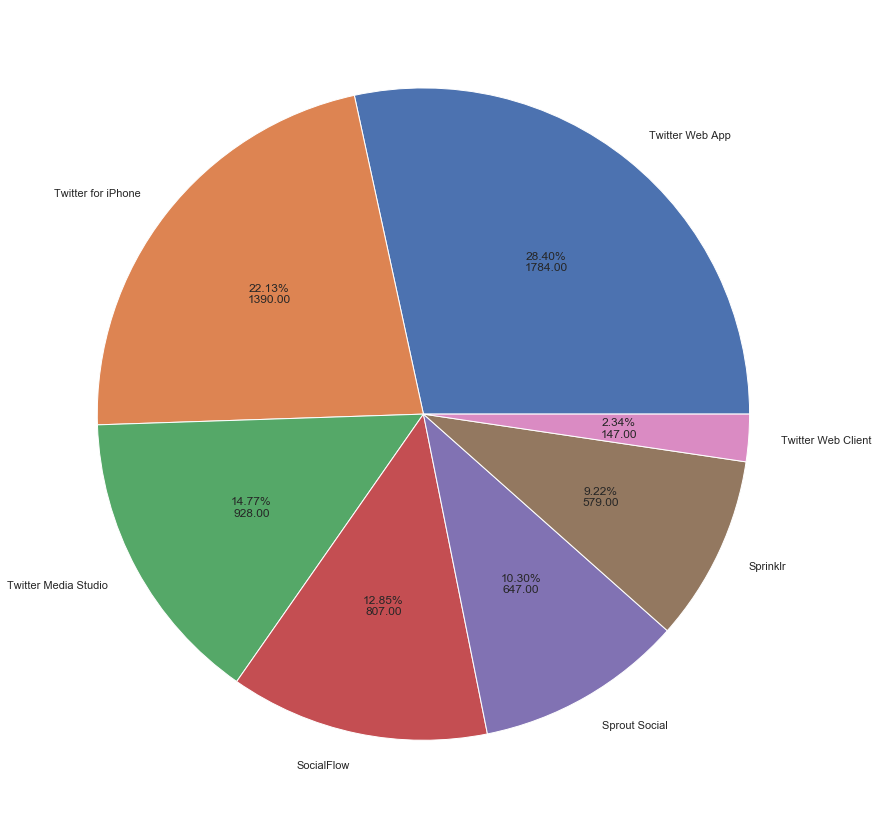

In [24]:
total = data_frame_not_elon['source'].value_counts().values.sum()
plt.pie(data_frame_not_elon['source'].value_counts().values, labels=data_frame_not_elon['source'].value_counts().index, autopct=fmt);


##### Język wpisu

Analizując języki wpisu, widać iż w obu przypadkach dominuje język angielski. Wpisy Elona Muska w zauważalnej części,
nie mają językowej zawartości(wpis jest pusty), takie wpisy to około 10% całej aktywności. Podobne zjawisko nie zachodzi
w przypadku pozostałych użytkowników. 

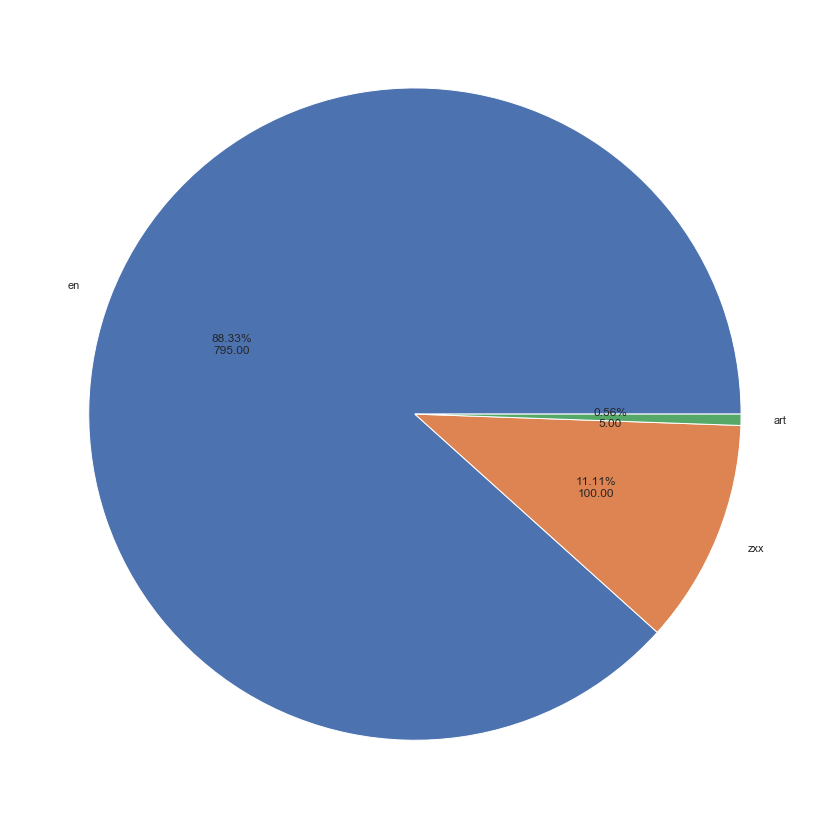

In [25]:
total = data_frame_elon['lang'].value_counts().values.sum()
plt.pie(data_frame_elon['lang'].value_counts().values, labels=data_frame_elon['lang'].value_counts().index, autopct=fmt);

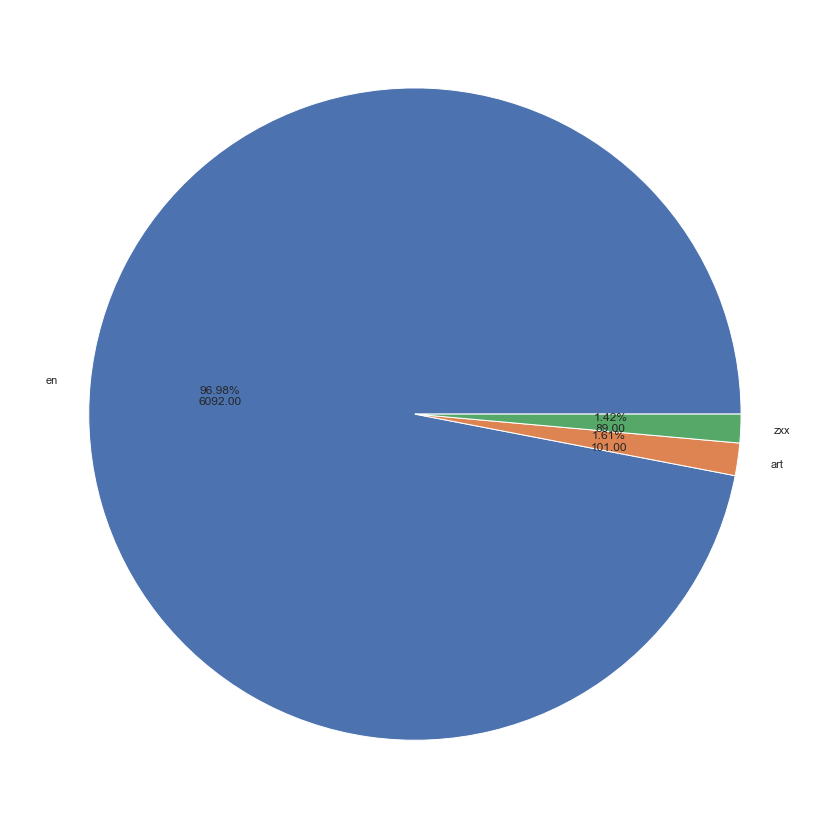

In [26]:
total = data_frame_not_elon['lang'].value_counts().values.sum()
plt.pie(data_frame_not_elon['lang'].value_counts().values, labels=data_frame_not_elon['lang'].value_counts().index, autopct=fmt);

### Reszta potencjalnych analiz

In [77]:
import plotly.express as px
fig = px.histogram(data_frame, y='context annotations domain 0', color='is Elon Musk', barmode='group', height=800).update_layout(
    xaxis_title="Context annotations domain", yaxis_title="Liczba wystąpień")
fig.show()

In [75]:
fig = px.histogram(data_frame, y='context annotations entity 0', color='is Elon Musk', barmode='group', height=800).update_layout(
    xaxis_title="Context annotations entity", yaxis_title="Liczba wystąpień")
fig.show()

#### Zakodowanie danych w celu dalszej analizy

In [29]:
used_annotations_domain = 3
    
columns_with_no_numeric_types = [
    'is Elon Musk',
    'source',
    'possibly sensitive',
    'lang']

add_annotations_columns_to_array(columns_with_no_numeric_types, used_annotations_domain)
no_numeric_data = data_frame[columns_with_no_numeric_types]
no_numeric_data_to_be_encoded = remove_null_annotations(used_annotations_domain, 'domain', no_numeric_data)

columns_to_be_merged = ['source', 'lang']
columns_to_be_merged = add_columns_to_be_merged(columns_to_be_merged, used_annotations_domain, 'domain')
no_numeric_data_encoded = hot_one_encode_annotation_columns(columns_to_be_merged, no_numeric_data_to_be_encoded, map_value) 


no_numeric_data_encoded.head()

,is Elon Musk,possibly sensitive,Actor,Athlete,Award Show,Book Genre,Brand,Brand Vertical,Business Taxonomy,Cities,...,Twitter Media Studio,Twitter Web App,Twitter Web Client,Twitter for iPhone,Unified Twitter Taxonomy,Video Game,Video Game Hardware,art,en,zxx
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


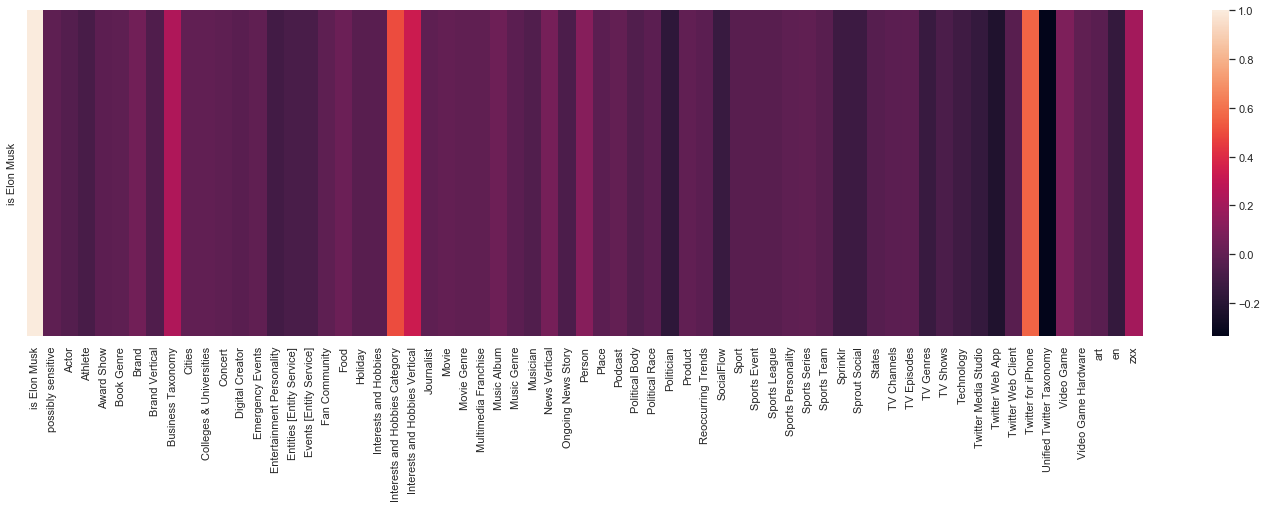

In [30]:
plt.figure(figsize=(25, 6))

corr_matrix=no_numeric_data_encoded.corr()[:1]
sb.heatmap(corr_matrix)



Na podstawie niżej wymienionych zmiennych będzie wykonywana klasyfikacja binarna tweetów Elona Muska:

* is Elon Musk - zmienna określa czy wpis należał do Elona Muska, jest kluczowa będzie wykorzystywana jako etykieta w trakcie klasyfikacji 
* source - źródło wpisu, czy jest to aplikacja czy strona *www*, z analizy danych zostało zauważone iż Elon dodaje wpisy tylko z aplikacji 
* lang	- język wpisu, w przypadku wpisów Elona duża część ma kategorie `und` (niezdefiniowany) 
* has_text - informacja czy tweet zawiera czysty tekst, bez linków, hashtagów czy emoji 
* has_link - informacja czy tweet zawiera link 
* has_hashtag - informacja czy tweet zawiera jakiś hashtag 
* has_at - informacja czy w wpisie byli oznaczeni inni użytkownicy 
* has_emoji	- informacja czy tweet zawiera emocji
* sentiment	- sentyment wpisu, obliczane tylko dla anglojęzycznych wpisów, bez emoji, linków, itd. Gdy tekst po oczyszczeniu jest pusty sentyment przyjmuje wartość dwa 
* retweet count	- liczba retweetów, Elon Musk miał średnio więcej retweetów
* reply count - liczba odpowiedzi, Elon Musk miał średnio więcej odpowiedzi
* like count - liczba polubień, Elon Musk miał średnio więcej polubień
* quote count - liczba cytowań, Elon Musk miał średnio więcej cytowań	

Dodatkowo zostaną wzięte pod uwagę konteksty wypowiedzi ich dziedzina oraz podmiot(tylko trzy pierwsze z 6 możliwych):

* context annotations entity 0 	
* context annotations entity 1 	
* context annotations entity 2
* context annotations entity 3

Informacje te będą przydatne ponieważ będą świadczyć o czym najczęściej pisze Elon Musk.

W zadaniu klasyfikacji zmienna **is Elon Musk** będzie etykietą reszta natomiast będzie zestawem cech, na podstawie których 
przygotowane modele będą dokonywać klasyfikacji. 
#### Dobroć modelu


W przypadku klasyfikacji tweetów Elona Muska zmagamy się z problemem niezbilansowanego zbioru danych, 
wpisy Elona Muska stanowią między innymi około 12%. W takim przypadku poleganie na dokładności klasyfikacji może dawać
fałszywe poczucie dobrego działania modelu(model może osiągnąć wysoką dokładność, klasyfikując wszystkie próbki jako klasę dominującą).
 Do analizy działania modelu zostały wykorzystane następujące wskaźniki:

* Macierz pomyłek 
* Precyzja 
* Zwrot 
* Dokładność 
* Krzywe uczenia 


In [80]:
used_annotations_domain = 4
used_annotations_entity = 0
    
columns_to_be_dropped = [
    'created at',
    'possibly sensitive',
    'annotations',
    'retweet count',
    'like count',
    'quote count',
    'reply count',
    'sentiment',
    'subjectivity',
    'lang'] 

add_annotations_columns_to_be_drooped(used_annotations_entity, 'entity', columns_to_be_dropped)
add_annotations_columns_to_be_drooped(used_annotations_domain, 'domain', columns_to_be_dropped)


data_frame_to_be_encoded = data_frame.loc[:,~data_frame.columns.duplicated()].copy()
data_frame_to_be_encoded.drop(columns_to_be_dropped, axis=1, inplace=True)

#### Wygląd ramki danych

In [81]:
data_frame_to_be_encoded.head()

,is Elon Musk,source,has_text,has_link,has_hashtag,has_at,has_emoji,context annotations domain 0,context annotations domain 1,context annotations domain 2,context annotations domain 3
1,1,Twitter for iPhone,1,1,0,0,0,Person,Politician,Business Taxonomy,Business Taxonomy
2,1,Twitter for iPhone,1,0,0,0,0,Business Taxonomy,Business Taxonomy,Person,Interests and Hobbies Vertical
3,1,Twitter for iPhone,1,0,0,0,0,Business Taxonomy,Business Taxonomy,Person,Interests and Hobbies Vertical
4,1,Twitter for iPhone,1,0,0,0,0,Business Taxonomy,Business Taxonomy,Person,Interests and Hobbies Vertical
5,1,Twitter for iPhone,1,0,0,0,0,Business Taxonomy,Business Taxonomy,Person,Interests and Hobbies Vertical


In [82]:
data_frame_to_be_encoded = remove_null_annotations(used_annotations_domain, 'domain', data_frame_to_be_encoded)
data_frame_to_be_encoded = remove_null_annotations(used_annotations_entity, 'entity', data_frame_to_be_encoded)
columns_to_be_merged = ['source']
columns_to_be_merged = add_columns_to_be_merged(columns_to_be_merged, used_annotations_domain, 'domain')
columns_to_be_merged = add_columns_to_be_merged(columns_to_be_merged, used_annotations_entity, 'entity')

data_frame_encoded = hot_one_encode_annotation_columns(columns_to_be_merged, data_frame_to_be_encoded, map_value) 

#### Przykład zakodowanych danych

In [83]:
data_frame_encoded.head()

,is Elon Musk,has_text,has_link,has_hashtag,has_at,has_emoji,Actor,Athlete,Award Show,Book Genre,...,TV Shows,Technology,Twitter Media Studio,Twitter Web App,Twitter Web Client,Twitter for iPhone,Unified Twitter Taxonomy,Video Game,Video Game Hardware,Weather
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0



#### Podział danych na etykiety i zbiór cech

Etykiety są wartościami pobranymi z pierwszej kolumny, pozostałe kolumny to wartości wektora cech. 

In [84]:
y = data_frame_encoded.iloc[:, 0]
x = data_frame_encoded.iloc[:, 1:]

#### Podział na zbiór testowych oraz treningowy

Przygotowane dane są podzielone w następujący sposób:
* 80% - zbiór treningowy
* 20% - zbiór testowy

Dodatkowo wykorzystany zostaje parametr **stratify**, który pozwoli zachować proporcje między klasami w zbiorze treningowym oraz  testowym.

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [86]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


svm_classifier = SVC(C=4)
svm_classifier.fit(x_train, y_train)

labels_predicted_svm = svm_classifier.predict(x_test)

print(f'SVM Classifier accuracy:  {100*accuracy_score(labels_predicted_svm, y_test)}[%]')
print(classification_report(y_test, labels_predicted_svm))
print(confusion_matrix(y_test, labels_predicted_svm))

SVM Classifier accuracy:  99.32935916542473[%]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1162
           1       0.97      0.98      0.98       180

    accuracy                           0.99      1342
   macro avg       0.98      0.99      0.99      1342
weighted avg       0.99      0.99      0.99      1342

[[1156    6]
 [   3  177]]


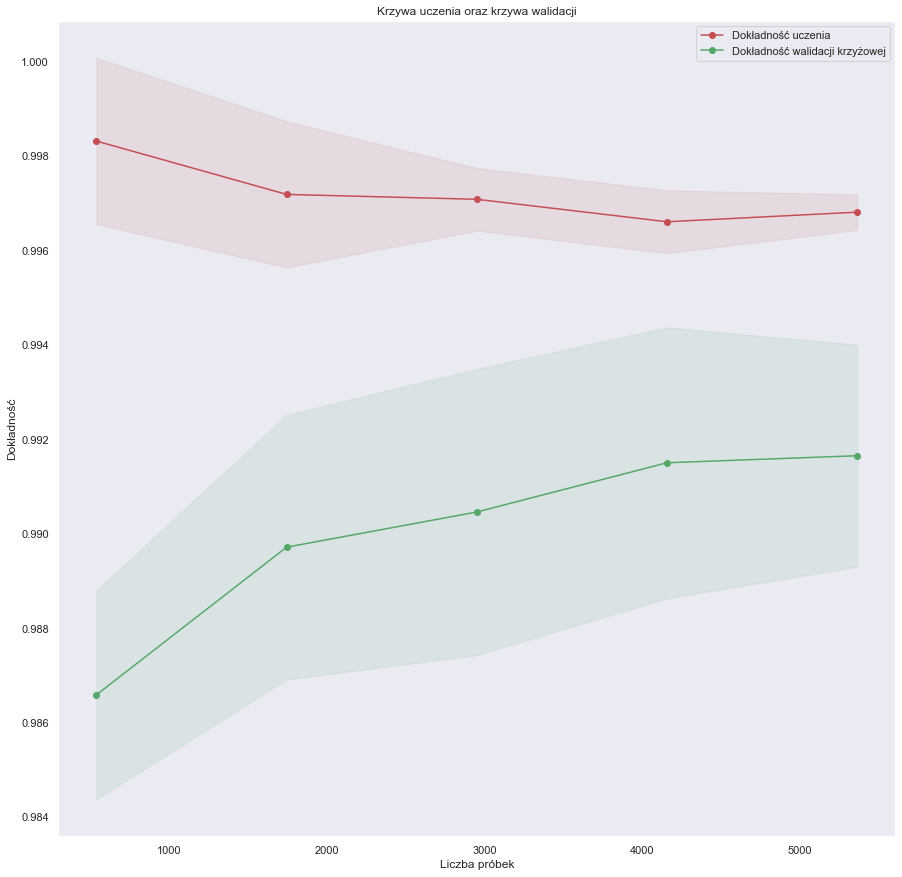

In [87]:
plot_learning_curve(svm_classifier, x, y, cv=cv, n_jobs=4)

#### Wielowarstwowy Perceptron

Jako pierwszy model zastosowano wielowarstwowy perceptron. Obserwując wyniki klasyfikacji można zauważyć takie cechy jak:
* Największy problem widać w macierzy pomyłek, gdzie widać przypadki FP oraz FN, czyli przypisano 52 próbek z klasy pierwszej(nie Elon)
do klasy drugiej(Elon) oraz 8 z klasy drugiej do klasy pierwszej.
* Współczynniki czułości w obu przypadkach przewyższa 0.90, podniesienie wartości precyzji polepszyłoby działanie modelu  
* Wysoką dokładność 


In [88]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes = (35, 25), random_state = 42, activation= 'relu', max_iter=500)
mlp_classifier.fit(x_train, y_train)

labels_predicted_mlp = mlp_classifier.predict(x_test)

print(f'MLPClassifier accuracy:  {100*accuracy_score(labels_predicted_mlp, y_test)}[%]')
print(classification_report(y_test, labels_predicted_mlp))
print(confusion_matrix(y_test, labels_predicted_mlp))

MLPClassifier accuracy:  99.32935916542473[%]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1162
           1       0.97      0.98      0.98       180

    accuracy                           0.99      1342
   macro avg       0.98      0.99      0.99      1342
weighted avg       0.99      0.99      0.99      1342

[[1156    6]
 [   3  177]]


#### Krzywa uczenia 

Analizując krzywą uczenia można zauważyć dwie główne cechy:
* Zwiększanie ilości obserwacji nie poprawia dokładności
* Krzywa uczenia nie ma symptomów przeuczenia, dokładność zbioru treningowego jest zbliżona do zbioru testowego  

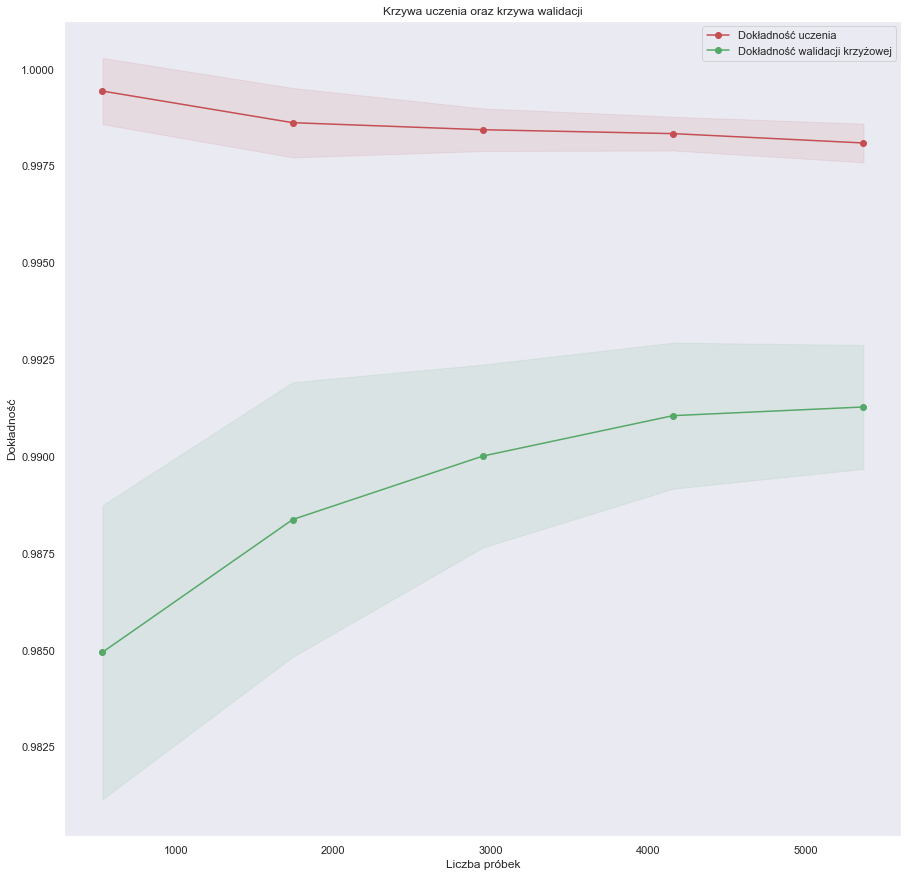

In [89]:
plot_learning_curve(mlp_classifier, x, y, cv=cv, n_jobs=4);

#### Drzewo Decyzyjne

Jako drugi model wykorzystano drzewo decyzyjne.Obserwując wyniki klasyfikacji można zauważyć:
* Klasyfikator prawie się nie mylił na zbiorze testowym blednie zaklasyfikował tylko 15 próbek.
* Obie wartości precyzji i zwrotu osiągają wartości bliskie 1
* Dokładność na poziomie 99%

In [90]:
from sklearn import tree

tree_cls = tree.DecisionTreeClassifier(random_state=42)
tree_cls = tree_cls.fit(x_train, y_train)

labels_predicted_tree = tree_cls.predict(x_test)
print(f'DecisionTreeClassifier accuracy:  {100*accuracy_score(labels_predicted_tree, y_test)}[%]')
print(classification_report(y_test, labels_predicted_tree))
print(confusion_matrix(y_test, labels_predicted_tree))

DecisionTreeClassifier accuracy:  99.03129657228018[%]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1162
           1       0.95      0.98      0.96       180

    accuracy                           0.99      1342
   macro avg       0.97      0.99      0.98      1342
weighted avg       0.99      0.99      0.99      1342

[[1152   10]
 [   3  177]]



#### Krzywa uczenia 

Analizując krzywą uczenia można zauważyć dwie główne cechy:
* Zwiększanie ilości obserwacji poprawia dokładność zbioru testowego 
* Krzywa uczenia może wyglądać jakby model był przeuczony jednak różnica między  zbiorem testowym a treningowym w finalnej fazie wynosi mniej niż 1.5%

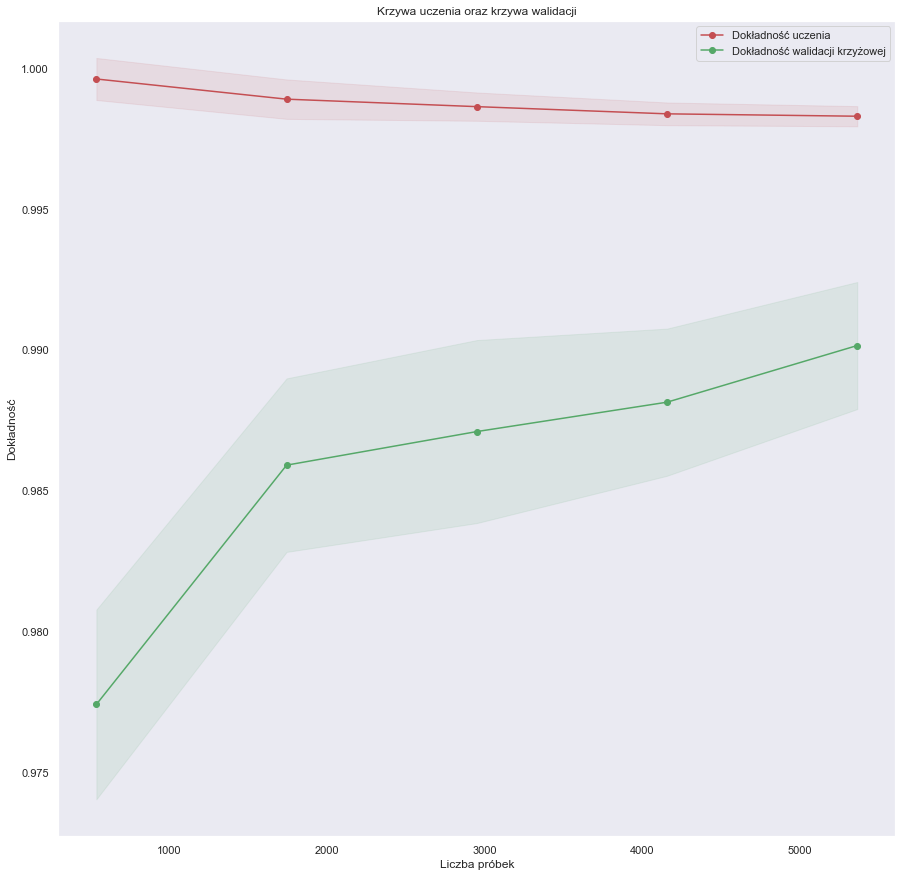

In [91]:
plot_learning_curve(tree_cls, x, y, cv=cv, n_jobs=4)

#### Reprezentacja drzewa edycyjnego

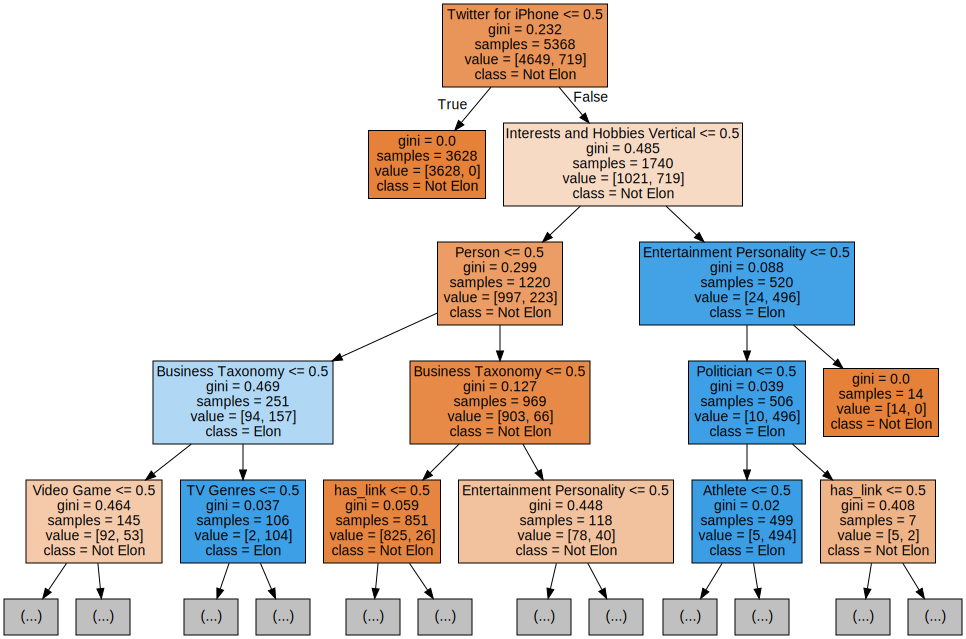

In [92]:
import graphviz
dot_data = tree.export_graphviz(tree_cls, filled=True, feature_names = x.columns.values.tolist(), class_names = ['Not Elon', 'Elon'], max_depth=4)
graph = graphviz.Source(dot_data, format="png") 
graph

### Podsumowanie


Wybrane zmienne pozwoliły osiągnąć bardzo skuteczne modele. Analiza macierzy pomyłek uwydatniła problem niezbalansowanego 
zbioru danych. Klasyfikator oparty o drzewa decyzyjne dał dużo lepszy rezultat. Dalsza praca nad doborem hiperparametrów
oraz wybranie lepszego zbioru cech może usprawnić działanie klasyfikatorów   